In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  RidgeCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import shap
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt


/Users/hungnguyen/miniforge3/envs/REDI/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/hungnguyen/miniforge3/envs/REDI/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def del

### Some helper functions

In [2]:
def get_score(model, feature, target):
    pred = model.predict(feature)
    score = pd.DataFrame(pred, columns=['Prediction'], index=feature.index)
    score['GroundTruth'] = np.array(target)
    score['AbsoluteError'] = abs(score['GroundTruth'] - score['Prediction'])
    return score

def get_doubtful_values(score, error=1.5):
    return score[score['AbsoluteError'] > error]

def get_truthful_values(score, error=0.5):
    return score[score['AbsoluteError'] < error]

### Load cleaned data

In [3]:
data = pd.read_csv("data/data_cleaned.csv")
data = data.drop(["Unnamed: 0"], axis=1)

### Train a model

In [4]:
y = data["OverallQual"]
X = data.drop(["OverallQual", 'SalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=100, stratify=y )

ridge = RidgeCV()
ridge.fit(X_train, y_train)
print(ridge.score(X_test, y_test))

0.7545168181975037


### Loc doubtful and truthful values

In [5]:
y_pred = ridge.predict(X)
y_score = get_score(ridge, X, y)

y_correct = get_truthful_values(y_score)
y_doubt = get_doubtful_values(y_score)


### Get explanation for original model

In [6]:
'''
Experiment:
- Original dataset, get doubtful value
- Corrupt this attrubute (the non-doubtful)
- See if the model discover the pattern.
'''
explainer = shap.Explainer(ridge, X, algorithm="linear", seed=100)
shap_values = explainer(X)

In [7]:
"""
Get data that only include the correct prediction.
Two indexes need to be kept.
"""
data_correct = data.iloc[y_correct.index]
data_correct['data_index'] = data_correct.index
data_correct = data_correct.reset_index(drop=True)
data_correct['index'] = data_correct.index
data_correct.set_index(['index', 'data_index'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Corrupt OverallQual on data_correct dataframe.

In [8]:

#variables
# OverallQual_sample_fraction = 0.01
top = 3
bottom = 1

at_least = False
OverallQual_sample_fraction_list = [
                                    0.01,
                                    0.02,
                                    0.05,
                                    0.1,
                                    0.15,
                                    0.2,
                                    0.3,
                                    0.5,
                                    ]
for OverallQual_sample_fraction in OverallQual_sample_fraction_list:

    corruption_list = []
    old_new_value = OrderedDict()

    data_to_corrupt = data_correct.copy()

    corruption_index_list = sorted(data_to_corrupt.sample(frac = OverallQual_sample_fraction, random_state=1).index)
    for i in corruption_index_list:
        old = data_to_corrupt.loc[i, 'OverallQual']
        new = np.random.randint(1, 11, 1)[0]

        while new == old or abs(old - new) >= top  or abs(old - new) < bottom:
            new = np.random.randint(1, 11, 1)[0]

        data_to_corrupt.loc[i, 'OverallQual'] = new
        corruption_list.append(i)
        old_new_value[i[0]] = (old, new)
    print("Corrupted  percentage: ", OverallQual_sample_fraction, len(corruption_list))

    y_corrupted = data_to_corrupt["OverallQual"]
    X_corrupted = data_to_corrupt.drop(["OverallQual", 'SalePrice'], axis=1)

    X_train_cor, X_test_cor, y_train_cor, y_test_cor = train_test_split(X_corrupted, y_corrupted, test_size=0.1,random_state=100)
    ridge_corrupt = RidgeCV()
    ridge_corrupt.fit(X_train_cor, y_train_cor)
    print("Model accuracy: ", ridge_corrupt.score(X_test_cor, y_test_cor))

    y_corrupted_score = get_score(ridge_corrupt, X_corrupted, y_corrupted)
    # y_corrupted_doubt = get_doubtful_values(y_corrupted_score)
    y_corrupted_score = y_corrupted_score.rename(
        columns={'GroundTruth': 'CorruptedTruth', 'AbsoluteError': 'CorruptedError'})
    y_corrupted_score['GroundTruth'] = y_corrupted_score.index.get_level_values(1).map(
        y[y_corrupted_score.index.get_level_values(1)])
    y_corrupted_score['Corrupted'] = y_corrupted_score['GroundTruth'] != y_corrupted_score['CorruptedTruth']
    y_corrupted_score['OrgPredict'] = y_corrupted_score.index.get_level_values(1). \
        map(y_score.loc[y_corrupted_score.index.get_level_values(1)]['Prediction'])
    y_corrupted_score = y_corrupted_score[
        ['Prediction', 'OrgPredict', 'CorruptedTruth', 'GroundTruth', 'Corrupted', 'CorruptedError']]
    y_corrupted_list = y_corrupted_score.loc[corruption_list]
    y_corrupted_doubt = y_corrupted_score[y_corrupted_score['CorruptedError'] > 1.5]
    print("TP: ", len(y_corrupted_doubt[y_corrupted_doubt['Corrupted'] == True]) / len(corruption_list))
    print("FP: ", len(y_corrupted_doubt[y_corrupted_doubt['Corrupted'] == False]) / len(y_corrupted_doubt))
    print("----")


Corrupted  percentage:  0.01 16
Model accuracy:  0.9181009081446738
TP:  0.5625
FP:  0.0
----
Corrupted  percentage:  0.02 31
Model accuracy:  0.898402004926595
TP:  0.3870967741935484
FP:  0.0
----
Corrupted  percentage:  0.05 78
Model accuracy:  0.8140888154566843
TP:  0.4358974358974359
FP:  0.0
----
Corrupted  percentage:  0.1 157
Model accuracy:  0.7328122086678114
TP:  0.5286624203821656
FP:  0.0
----
Corrupted  percentage:  0.15 235
Model accuracy:  0.7201310153506634
TP:  0.46808510638297873
FP:  0.0
----
Corrupted  percentage:  0.2 313
Model accuracy:  0.6430756481459183
TP:  0.4504792332268371
FP:  0.0
----
Corrupted  percentage:  0.3 470
Model accuracy:  0.6237266448791436
TP:  0.4851063829787234
FP:  0.0
----
Corrupted  percentage:  0.5 784
Model accuracy:  0.497845641801825
TP:  0.46683673469387754
FP:  0.0
----


In [9]:
y_corrupted_list

,,Prediction,OrgPredict,CorruptedTruth,GroundTruth,Corrupted,CorruptedError
index,data_index,,,,,,
2,2,7.261479,7.233971,8,7,True,0.738521
3,4,7.682588,7.659763,6,8,True,1.682588
5,9,5.810384,5.317536,7,5,True,1.189616
6,10,5.046713,4.868929,6,5,True,0.953287
8,12,4.898756,4.880570,6,5,True,1.101244
...,...,...,...,...,...,...,...
1557,2892,5.552749,5.628263,4,6,True,1.552749
1558,2895,5.697394,5.701577,7,6,True,1.302606
1560,2898,7.859989,8.029033,6,8,True,1.859989


In [10]:
shap.initjs()
explainer_corruption = shap.Explainer(ridge_corrupt, X_corrupted, algorithm="linear", seed=100)
shap_values_corruption = explainer_corruption(X_corrupted)

In [11]:
def split_explanation_to_cohort_overallQual(shap_values_to_explain, data_to_explain):
    overallQual_explanation = {}

    for i in range(len(shap_values_to_explain)):
        overallQual = int(data_to_explain.iloc[i]['OverallQual'])
        if overallQual not in overallQual_explanation:
            overallQual_explanation[overallQual] = shap.Explanation(values=shap_values_to_explain.values[i],
                                                                    base_values=shap_values_to_explain.base_values[i],
                                                                    data=shap_values_to_explain.data[i],
                                                                    feature_names=shap_values_to_explain.feature_names)
        else:
            overallQual_explanation[overallQual].base_values = np.append(overallQual_explanation[overallQual].base_values,
                                                                         shap_values_to_explain.base_values[i])
            overallQual_explanation[overallQual].values = np.vstack([overallQual_explanation[overallQual].values,
                                                                     shap_values_to_explain.values[i]])
            overallQual_explanation[overallQual].data = np.vstack([overallQual_explanation[overallQual].data,
                                                                   shap_values_to_explain.data[i]])
    return overallQual_explanation

overallQual_explanation_original = split_explanation_to_cohort_overallQual(shap_values, data)
overallQual_explanation_corrupted = split_explanation_to_cohort_overallQual(shap_values_corruption, data_to_corrupt)


8


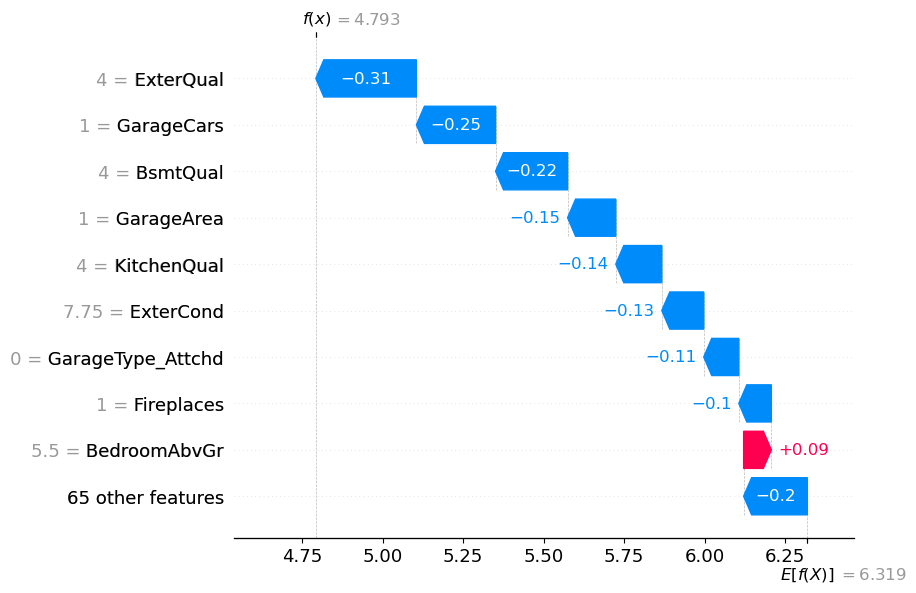

In [12]:
print(y[1349])
shap.plots.waterfall(shap_values[1349], max_display=10)

### Plot differences in explanation between corrupted and original data.


### Plot differences in explanation between corrupted and original data.

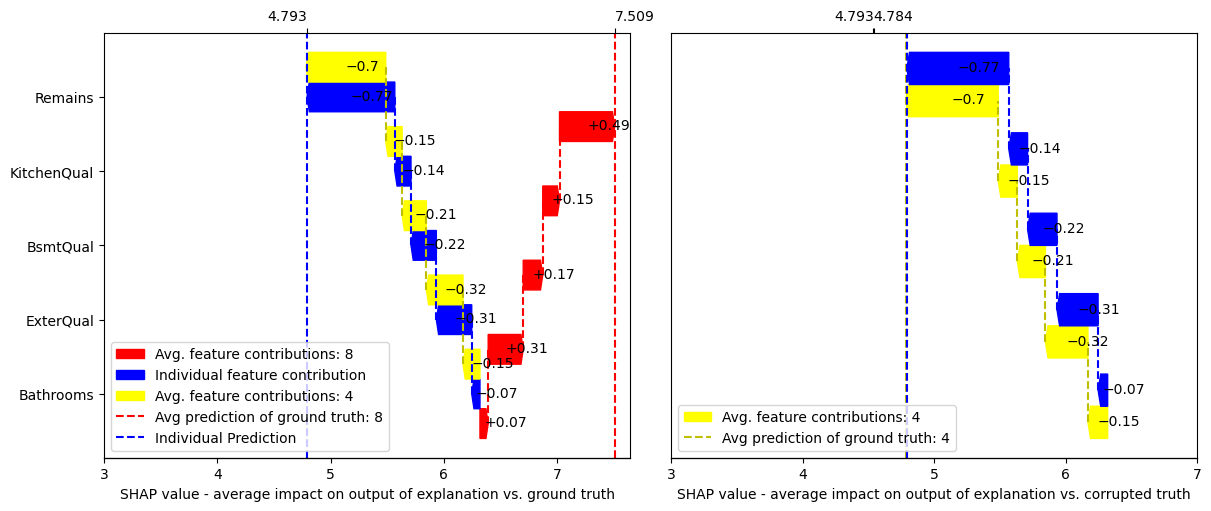

In [17]:
import re

def format_value(s, format_str):
    if not issubclass(type(s), str):
        s = format_str % s
    s = re.sub(r'\.?0+$', '', s)
    if s[0] == "-":
        s = u"\u2212" + s[1:]
    return s


def arrow_plot_comparing_explanations_values(value_to_explain,
                                             value_to_compare_1,
                                             value_to_compare_2,
                                             threshold=0.1):




    individual_value_corrupted = value_to_explain


    ground_truth = value_to_compare_1
    corrupted_truth = value_to_compare_2

    value_original = overallQual_explanation_original[ground_truth].values.mean(0)
    value_corrupted = overallQual_explanation_original[corrupted_truth].values.mean(0)


    base_value_original = overallQual_explanation_original[ground_truth].base_values.mean(0)
    base_value_corrupted = overallQual_explanation_original[corrupted_truth].base_values.mean(0)
    # base_value_individual = shap_values_corruption[corruption_list[corruption_index][0]].base_values

    base_value_individual = shap_values[1349].base_values


    # Keep the list of features that are removed. Sum all those into one.
    remains_original = 0
    remains_corrupted = 0
    remains_individual_corrupted = 0
    remove_list = []

    # Remove features that are below threshold and sum those together.
    for index in range(len(value_original)):
        if abs(value_corrupted[index]) < threshold and abs(value_original[index]) < threshold:
            remove_list.append(index)
            remains_corrupted += value_corrupted[index]
            remains_original += value_original[index]
            remains_individual_corrupted += individual_value_corrupted[index]

    value_original = np.delete(value_original, remove_list)
    value_original = np.append(value_original, remains_original)

    value_corrupted = np.delete(value_corrupted, remove_list)
    value_corrupted = np.append(value_corrupted, remains_corrupted)

    individual_value_corrupted = np.delete(individual_value_corrupted, remove_list)
    individual_value_corrupted = np.append(individual_value_corrupted, remains_individual_corrupted)


    col_list = np.delete(X.columns.to_numpy(), remove_list)
    col_list = np.append(col_list, 'Remains')

    ground_truth_avg_string = 'Avg. feature contributions: ' + str(ground_truth)
    corrupted_truth_avg_string = 'Avg. feature contributions: ' + str(corrupted_truth)
    corrupted_explanation_string = 'Individual feature contribution'
    dict_fig_1 = OrderedDict(
        {
        ground_truth_avg_string: value_original,
        corrupted_explanation_string: individual_value_corrupted,
        corrupted_truth_avg_string: value_corrupted,
    })

    dict_fig_2 = OrderedDict(
        {
        corrupted_truth_avg_string: value_corrupted,
        corrupted_explanation_string: individual_value_corrupted,

    })


    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=2, layout='constrained',figsize=(12, len(col_list)) )
    width = 0.4  # the width of the arrow
    head_length = 0.02
    offset_text = 0.04
    multiplier = 0
    label_locations = np.arange(len(col_list))  # the label locations


    for attribute, measurement in dict_fig_1.items():
        offset = width * multiplier
        # rects = ax.barh(label_locations + offset, np.round(measurement, 3), width, label=attribute )

        if attribute == ground_truth_avg_string:
            base = base_value_original
            for i in range(len(measurement)):
                contribution = measurement[i]

                if i == 0:
                    label = attribute
                else:
                    label = None

                ax[0].arrow(base,
                         label_locations[i] + offset,
                         contribution,
                         0,
                         length_includes_head=True,
                         head_width=width,
                         head_length=head_length,
                         width=width,
                         color='red',
                         label=label,
                         )

                ax[0].text(
                    (base + base + contribution) / 2,
                    label_locations[i] + offset - offset_text,
                    format_value(contribution, '%+0.02f'),
                    color="black",
                    fontsize=10,
                    )
                base += contribution

                if  i < len(measurement) - 1:
                    ax[0].plot([base, base], [label_locations[i] + offset, label_locations[i + 1] + offset],   color = 'r', linestyle = '--',)
            ground_truth_avg_pred = base
        elif attribute == corrupted_explanation_string:
            base = base_value_individual
            for i in range(len(measurement)):
                contribution = measurement[i]
                if i == 0: label = attribute
                else: label = None

                ax[0].arrow(x=base,
                         y=label_locations[i] + offset,
                         dx=contribution,
                         dy=0,
                         length_includes_head=True,
                         head_width=width,
                         head_length=head_length,
                         width=width,
                         color='blue',
                         label=label,
                         )
                ax[0].text((base + base + contribution) / 2,
                        label_locations[i] + offset - offset_text,
                        format_value(contribution, '%+0.02f'),
                        color="black",
                        fontsize=10,
                        )

                base += contribution

                if  i < len(measurement) - 1:
                    ax[0].plot([base, base], [label_locations[i] + offset, label_locations[i + 1] + offset],   color = 'b', linestyle = '--',)
            corrupted_explanation_pred = base
        elif attribute == corrupted_truth_avg_string:
            base = base_value_corrupted
            for i in range(len(measurement)):
                contribution = measurement[i]
                if i == 0: label = attribute
                else: label = None
                ax[0].arrow(x=base,
                         y=label_locations[i] + offset,
                         dx=contribution,
                         dy=0,
                         length_includes_head=True,
                         head_width=width,
                         head_length=head_length,
                         width=width,
                         color='yellow',
                         label=label,
                         )
                ax[0].text((base + base + contribution) / 2,
                        label_locations[i] + offset - offset_text,
                        format_value(contribution, '%+0.02f'),
                        color="black",
                        fontsize=10,
                        )

                base += contribution

                if  i < len(measurement) - 1:
                    ax[0].plot([base, base], [label_locations[i] + offset, label_locations[i + 1] + offset],   color = 'y', linestyle = '--',)
            corrupted_truth_avg_pred = base

        multiplier += 1

    multiplier = 0

    for attribute, measurement in dict_fig_2.items():
        offset = width * multiplier

        if attribute == corrupted_truth_avg_string:
            base = base_value_corrupted
            for i in range(len(measurement)):
                contribution = measurement[i]
                if i == 0: label = attribute
                else: label = None
                ax[1].arrow(x=base,
                         y=label_locations[i] + offset,
                         dx=contribution,
                         dy=0,
                         length_includes_head=True,
                         head_width=width,
                         head_length=head_length,
                         width=width,
                         color='yellow',
                         label=label,
                         )
                ax[1].text((base + base + contribution) / 2,
                        label_locations[i] + offset - offset_text,
                        format_value(contribution, '%+0.02f'),
                        color="black",
                        fontsize=10,
                        )

                base += contribution

                if  i < len(measurement) - 1:
                    ax[1].plot([base, base], [label_locations[i] + offset, label_locations[i + 1] + offset],   color = 'y', linestyle = '--',)
            corrupted_truth_avg_pred = base

        else:
            base = base_value_individual
            for i in range(len(measurement)):
                contribution = measurement[i]
                if i == 0: label = attribute
                else: label = None
                ax[1].arrow(x=base,
                         y=label_locations[i] + offset,
                         dx=contribution,
                         dy=0,
                         length_includes_head=True,
                         head_width=width,
                         head_length=head_length,
                         width=width,
                         color='blue',
                         # label=label,
                         )
                ax[1].text((base + base + contribution) / 2,
                        label_locations[i] + offset - offset_text,
                        format_value(contribution, '%+0.02f'),
                        color="black",
                        fontsize=10,
                        )

                base += contribution

                if  i < len(measurement) - 1:
                    ax[1].plot([base, base], [label_locations[i] + offset, label_locations[i + 1] + offset],   color = 'b', linestyle = '--',)
            corrupted_explanation_pred = base
        multiplier += 1

    # Draw base value lines
    ax[0].axvline(x = ground_truth_avg_pred, color = 'r', linestyle = '--', label='Avg prediction of ground truth: ' + str(ground_truth))
    ax[0].axvline(x = corrupted_explanation_pred, color = 'b', linestyle = '--', label='Individual Prediction')
    ax[1].axvline(x = corrupted_truth_avg_pred, color = 'y', linestyle = '--', label='Avg prediction of ground truth: ' + str(corrupted_truth))
    ax[1].axvline(x = corrupted_explanation_pred, color = 'b', linestyle = '--')

    # ax[0].set_title('Explanation change after corruption')
    ax[0].set_yticks(label_locations + width, col_list)
    ax[1].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax[1].get_yaxis().set_visible(False)


    # Set x ticks

    max_value_original = np.sum(value_original) + base_value_original
    max_value_corrupted = np.sum(value_corrupted) + base_value_corrupted
    max_value_individual = np.sum(value_original) + base_value_individual

    max_tick = np.round(max(base_value_original, base_value_corrupted, max_value_original, max_value_corrupted, max_value_individual, base_value_individual) + 0.1 , 2)
    min_tick = np.round(min(base_value_original, base_value_corrupted, max_value_original, max_value_corrupted, max_value_individual, base_value_individual) - 0.1, 2)

    max_tick = 7
    min_tick = 3

    tick_step = 5


    ax[0].set_xticks(np.linspace(min_tick, max_tick, tick_step))
    ax[1].set_xticks(np.linspace(min_tick, max_tick, tick_step))

    ax[0].set_xlabel('SHAP value - average impact on output of explanation vs. ground truth')
    ax[1].set_xlabel('SHAP value - average impact on output of explanation vs. corrupted truth')

    xmin, xmax = ax[0].get_xlim()

    # Find poisition to show the base value, so that they don't overlap. If they overlap, show them in the middle.
    if ground_truth_avg_pred > corrupted_explanation_pred:
        original_ha = 'left'
        individual_ha = 'right'
    elif ground_truth_avg_pred < corrupted_explanation_pred:
        original_ha = 'right'
        individual_ha = 'left'

    # Show base values
    ax2 = ax[0].twiny()
    ax2.set_xlim(xmin, xmax)
    ax2.set_xticks([ ground_truth_avg_pred])
    ax2.set_xticklabels([ format_value(ground_truth_avg_pred, "%0.03f")], ha=original_ha)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    if format_value(corrupted_explanation_pred, "%0.03f") != format_value(base_value_original, "%0.03f"):
        ax3 = ax[0].twiny()
        ax3.set_xlim(xmin, xmax)
        ax3.set_xticks([ corrupted_explanation_pred])
        ax3.set_xticklabels([format_value(corrupted_explanation_pred, "%0.03f")], ha=individual_ha)
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.spines['left'].set_visible(False)

    if corrupted_explanation_pred > corrupted_truth_avg_pred:
        individual_ha = 'right'
        corrupted_ha = 'left'
    elif corrupted_explanation_pred < corrupted_truth_avg_pred:
        corrupted_ha = 'left'
        individual_ha = 'right'


    ax5 = ax[1].twiny()
    ax5.set_xlim(xmin, xmax)
    ax5.set_xticks([ corrupted_truth_avg_pred])
    ax5.set_xticklabels([format_value(corrupted_truth_avg_pred, "%0.03f")], ha=corrupted_ha)
    ax5.spines['right'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.spines['left'].set_visible(False)

    if format_value(corrupted_explanation_pred, "%0.03f") != format_value(base_value_corrupted, "%0.03f"):
        ax4 = ax[1].twiny()
        ax4.set_xlim(xmin, xmax)
        ax4.set_xticks([ corrupted_explanation_pred])
        ax4.set_xticklabels([format_value(corrupted_explanation_pred, "%0.03f")], ha=individual_ha)
        ax4.spines['right'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        ax4.spines['left'].set_visible(False)



    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')


arrow_plot_comparing_explanations_values(shap_values[1349].values,
                                         8,
                                         4,
                                         threshold=0.1)

### similar plot to above but in bar plot instead of arrow plot (not used in paper)

In [ ]:
def bar_plot_comparing_explanations_values(corruption_index,
                                          threshold=0.1):

    # Get Shapley values
    individual_value_corrupted = shap_values_corruption[corruption_list[corruption_index][0]].values
    individual_value_original = shap_values[corruption_list[corruption_index][1]].values
    try:
        y_value = y_corrupted_doubt.loc[corruption_list[corruption_index]]
    except KeyError:
        raise RuntimeError('This corruption is not identified')



    assert y_value['Corrupted'] == True, 'This is not a corrupted data.'

    ground_truth = y_value['GroundTruth']
    corrupted_truth  = y_value['CorruptedTruth']

    value_original = overallQual_explanation_original[ground_truth].values.mean(0)
    value_corrupted = overallQual_explanation_original[corrupted_truth].values.mean(0)

    corrupted_prediction = y_value['Prediction']
    original_prediction = y_value['OrgPredict']

    # Keep the list of features that are removed. Sum all those into one.
    remains_original = 0
    remains_corrupted = 0
    remains_individual_original = 0
    remains_individual_corrupted = 0
    remove_list = []

    # Remove features that are below threshold and sum those together.
    for index in range(len(value_original)):
        if abs(value_corrupted[index]) < threshold and abs(value_original[index]) < threshold:
            remove_list.append(index)
            remains_corrupted += value_corrupted[index]
            remains_original += value_original[index]
            remains_individual_original += individual_value_original[index]
            remains_individual_corrupted += individual_value_corrupted[index]

    value_original = np.delete(value_original, remove_list)
    # value_original = np.append(value_original, remains_original)

    value_corrupted = np.delete(value_corrupted, remove_list)
    # value_corrupted = np.append(value_corrupted, remains_corrupted)

    individual_value_original = np.delete(individual_value_original, remove_list)
    # individual_value_original = np.append(individual_value_original, remains_individual_original)

    individual_value_corrupted = np.delete(individual_value_corrupted, remove_list)
    # individual_value_corrupted = np.append(individual_value_corrupted, remains_individual_corrupted)


    col_list = np.delete(X.columns.to_numpy(), remove_list)
    # col_list = np.append(col_list, 'Remains')

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, layout='constrained',figsize=(10, len(col_list) * 1.25))
    width = 0.2  # the width of the bars
    multiplier = 0

    ground_truth_avg_string = 'Ground Truth average: ' + str(ground_truth)
    corrupted_truth_avg_string = 'Ground Truth average: ' + str(corrupted_truth)
    original_explanation_string = 'Original Explanation average: ' + str(np.round(original_prediction, 3))
    corrupted_explanation_string = 'Corrupted Explanation average: ' + str(np.round(corrupted_prediction, 3))
    dict_avg = OrderedDict(
        {
        ground_truth_avg_string: value_original,
        original_explanation_string: individual_value_original,
        corrupted_explanation_string: individual_value_corrupted,
        corrupted_truth_avg_string: value_corrupted
    })
    label_locations = np.arange(len(col_list))  # the label locations
    for attribute, measurement in dict_avg.items():
        offset = width * multiplier
        rects = ax.barh(label_locations + offset , np.round(measurement, 3), width, label=attribute )
        ax.bar_label(rects, padding=7)
        multiplier += 1
    ax.set_title('Explanation change after corruption')
    ax.set_yticks(label_locations + width * 2, col_list)
    x_max = max(np.max(value_original), np.max(value_corrupted), np.max(individual_value_original), np.max(individual_value_corrupted))
    x_min = min(np.min(value_original), np.min(value_corrupted), np.min(individual_value_original), np.min(individual_value_corrupted))
    ax.set_xlim([x_min - 0.1, x_max + 0.1])
    ax.set_xlabel('SHAP value - average impact on output of each feature')

    # Revert the order of legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='best')


bar_plot_comparing_explanations_values(10, threshold=0.1)
